In [1]:
import json
from copy import deepcopy
# Load the COCO validation annotations
with open('/home/vinhvq11/Desktop/PDF_extraction/data_process/extract_elements_text/fci/output/gt_coco_fci_20240930.json') as f:
    val_data = json.load(f)

# Load the COCO format predictions
with open('/home/vinhvq11/Desktop/PDF_extraction/data_process/extract_elements_text/fci/output/fci_infer.json') as f:
    pred_data = json.load(f)


In [2]:
pred = deepcopy(val_data)
pred['annotations'] = pred_data
pred_data = pred

In [3]:
from collections import defaultdict

# Map annotations to images
annotations = defaultdict(list)
for ann in val_data['annotations']:
    annotations[ann['image_id']].append(ann)

# Map predictions to images
predictions = defaultdict(list)
for pred in pred_data['annotations']:
    predictions[pred['image_id']].append(pred)


In [4]:
def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    
    Parameters:
    box1, box2: Lists or tuples with coordinates [x1, y1, width, height]
    
    Returns:
    iou: IoU value
    """
    x1_1, y1_1, w1, h1 = box1
    x2_1, y2_1, w2, h2 = box2
    
    x1_2 = x1_1 + w1
    y1_2 = y1_1 + h1
    x2_2 = x2_1 + w2
    y2_2 = y2_1 + h2
    
    xi1 = max(x1_1, x2_1)
    yi1 = max(y1_1, y2_1)
    xi2 = min(x1_2, x2_2)
    yi2 = min(y1_2, y2_2)
    
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - inter_area
    
    iou = inter_area / union_area if union_area > 0 else 0
    
    return iou


In [5]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import numpy as np

def is_significant_overlap(box1, box2, threshold=0.9):
    """
    Check if the IoU between two bounding boxes is greater than the given threshold.
    
    Parameters:
    box1, box2: Lists or tuples with coordinates [x1, y1, width, height]
    threshold: float, IoU threshold
    
    Returns:
    bool: True if IoU > threshold, else False
    """
    iou = calculate_iou(box1, box2)
    return iou > threshold

# Initialize confusion matrix components
y_true = []
y_pred = []

for image_id in annotations.keys():
    gt_labels = [ann['category_id'] for ann in annotations[image_id]]
    pred_labels = [pred['category_id'] for pred in predictions.get(image_id, [])]
    
    gt_matched = [False] * len(gt_labels)
    pred_matched = [False] * len(pred_labels)
    
    for i, gt in enumerate(annotations[image_id]):
        for j, pred in enumerate(predictions.get(image_id, [])):
            if is_significant_overlap(gt['bbox'], pred['bbox']):
                gt_matched[i] = True
                pred_matched[j] = True
                y_true.append(gt['category_id'])
                y_pred.append(pred['category_id'])
    
    for i, matched in enumerate(gt_matched):
        if not matched:
            y_true.append(annotations[image_id][i]['category_id'])
            y_pred.append('background')
    
    for j, matched in enumerate(pred_matched):
        if not matched:
            y_true.append('background')
            y_pred.append(predictions[image_id][j]['category_id'])


In [6]:
# Confidence threshold
confidence_threshold = 0.5

# Initialize confusion matrix components
y_true = []
y_pred = []

for image_id in annotations.keys():
    gt_labels = [ann['category_id'] for ann in annotations[image_id]]
    gt_boxes = [ann['bbox'] for ann in annotations[image_id]]
    # gt_text = [ann['extracted_text'] for ann in annotations[image_id]]

    pred_labels = [pred['category_id'] for pred in predictions.get(image_id, []) if pred['score'] >= confidence_threshold]
    pred_boxes = [pred['bbox'] for pred in predictions.get(image_id, []) if pred['score'] >= confidence_threshold]
    # pre_text = [pred['extracted_text'] for pred in annotations[image_id]]
    gt_matched = [False] * len(gt_labels)
    pred_matched = [False] * len(pred_labels)
    
    for i, gt_box in enumerate(gt_boxes):
        for j, pred_box in enumerate(pred_boxes):
            if is_significant_overlap(gt_box, pred_box):
                gt_matched[i] = True
                pred_matched[j] = True
                y_true.append(gt_labels[i])
                y_pred.append(pred_labels[j])
                # if gt_text[i].strip() == pred_
    for i, matched in enumerate(gt_matched):
        if not matched:
            y_true.append(gt_labels[i])
            y_pred.append('background')
    
    for j, matched in enumerate(pred_matched):
        if not matched:
            y_true.append('background')
            y_pred.append(pred_labels[j])

# Convert category IDs to category names if necessary
category_id_to_name = {cat['id']: cat['name'] for cat in val_data['categories']}
category_id_to_name['background'] = 'background'

y_true = [category_id_to_name.get(label, 'background') for label in y_true]
y_pred = [category_id_to_name.get(label, 'background') for label in y_pred]

labels = list(category_id_to_name.values())

conf_mat = confusion_matrix(y_true, y_pred, labels=labels)


In [7]:
conf_mat_normalized = conf_mat#.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]


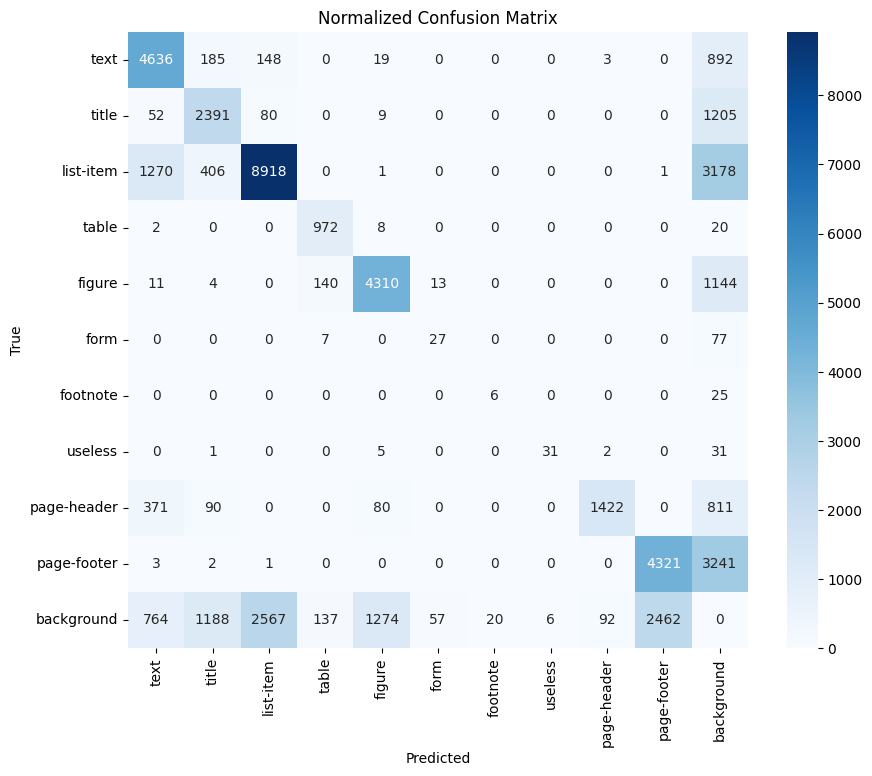

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_normalized, annot=True, fmt='.0f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()


In [14]:
precision = precision_score(y_true, y_pred, labels=labels, average=None, zero_division=0)
recall = recall_score(y_true, y_pred, labels=labels, average=None, zero_division=0)
print('Precision@0.9')
for label, score in zip(labels,precision):
    print(f'\t{label}:{score:.4f}')
print('Recall@0.9')
for label, score in zip(labels,recall):
    print(f'\t{label}:{score:.4f}')

Precision@0.9
	text:0.8758
	title:0.9020
	list-item:0.9214
	table:0.9597
	figure:0.7651
	form:0.8119
	footnote:0.5000
	useless:0.7292
	page-header:0.8428
	page-footer:0.7612
	background:0.0000
Recall@0.9
	text:0.8761
	title:0.9132
	list-item:0.9300
	table:0.9476
	figure:0.7937
	form:0.8723
	footnote:0.5714
	useless:0.7292
	page-header:0.8344
	page-footer:0.7626
	background:0.0000


# Evaluate by domain


In [10]:
import os
import pandas as pd
import json

# Path to the folder containing the JSON files
folder_path = 'eval_domain'

# Initialize a list to store the data
data_list = []

# Loop through each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.json'):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r') as file:
            data = json.load(file)
            # Extract the AP values
            ap_values = data['bbox']
            ap_values['filename'] = filename.replace('.json','')
            # Append the values to the list
            data_list.append(ap_values)

# Create a DataFrame from the list
df = pd.DataFrame(data_list)

# Set the index of the DataFrame to be the filenames
df.set_index('filename', inplace=True)

# Display the DataFrame
print(df)
df.to_csv('eval_domain.csv')
df.to_excel('eval_domain.xlsx')



                 AP       AP50       AP75        APs        APm        APl  \
filename                                                                     
qms       94.751269  99.675375  99.385690  67.348958  91.407223  98.424568   
law       93.155761  98.374978  96.519660  82.690251  84.794408  94.288629   
fpt       83.668147  90.356238  90.190419  90.099010  87.220657  85.255679   
finance   94.799112  99.110613  98.338465  70.990099  75.892488  97.143512   
bank      84.611766  96.530307  92.361789   0.000000  73.988014  87.814878   

            AP-text   AP-title  AP-list-item    AP-table  AP-figure  \
filename                                                              
qms       96.913080  95.477894     94.905332   98.693708  97.070847   
law       94.331687  95.813033     96.469290   98.818051  85.287623   
fpt       87.248676  87.985903     90.266655  100.000000  96.111611   
finance   93.746262  89.989206     94.759349   97.250041  93.049811   
bank      72.963468  86.506